In [137]:
import cv2
import base64
import numpy as np
import matplotlib.pyplot as plt

## 1. Image Preprocessing
---
**Goal:** <br>
M03 S24000 <br>
G00 Z10.0 <br>
6##################################### <br>
G00 X7 Y0 <br>
G00 Z0.5 <br>
G00 Z0 <br>
G01 Z-3 F500 <br>
G01 X1 Y6 F1000 <br>
G01 X4 Y9 <br>
G00 Z0.5 <br>
#########################End <br>
G00 Z10.0 <br>
G00 X0 Y0 <br>
M05 <br>
M30 <br>



In [147]:
# Params 
# Wie groß darf der Abstand sein, dass der Punkt zu der Kontour dazugehört
# Desto größer desto weniger Eckpunkte, desto ungenauer, desto schneller
# Beachte epsilon kann auch in abhänigkeit der Kantenlänge erstellt werden
fixed_epsilon = 1.5

use_dynamic_epsilon = True
max_epsilon = 3.5
min_epsilon = 1.5

In [158]:
edges = np.array([
       [  0,   0,   0,   0,   0,   0,   0, 255,   0,   0],
       [  0,   0,   0,   0,   0,   0, 255,   0,   0,   0],
       [  0,   0,   0,   0,   0, 255,   0,   0,   0,   0],
       [  0,   0,   0, 255, 255,   0,   0,   0,   0,   0],
       [  0,   0,   0, 255,   0,   0,   0,   0,   0, 255],
       [  0,   0, 255,   0,   0,   0,   0,   0, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0, 255,   0,   0],
       [  0,   0, 255,   0,   0,   0, 255,   0, 255,   0],
       [  0,   0,   0, 255,   0, 255,   0,   0,   0, 255],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]]).astype(np.uint8)

contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Führe die Approximation der Kontur durch Geradensegmente durch
# epsilon = 0.02 * cv2.arcLength(contours[0], True)  # Passe den Epsilon-Wert nach Bedarf an

edge_approximations = []

for i in range(len(contours)):
       edge_approx = cv2.approxPolyDP(contours[i], fixed_epsilon, True)
       
       # remove last element if it is already in contour
       if edge_approx[-1] in edge_approx[:-1]:
              edge_approx = edge_approx[:-1]
       
       edge_approximations.append(edge_approx)

In [159]:
edge_approximations

[array([[[9, 4]],
 
        [[5, 8]],
 
        [[7, 6]],
 
        [[9, 8]]], dtype=int32),
 array([[[7, 0]],
 
        [[1, 6]],
 
        [[3, 8]]], dtype=int32)]

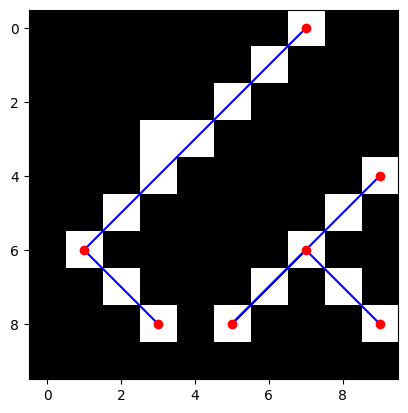

In [160]:
# Plot des Edge-Bildes
plt.imshow(edges, cmap='gray')

# Plot der approximierten Kanten als Linien mit blauer Farbe
for edge_approx in edge_approximations:
    x_approx = edge_approx[:, :, 0].flatten()
    y_approx = edge_approx[:, :, 1].flatten()
    plt.plot(x_approx, y_approx, color='blue')

    # Plot der Eckpunkte als rote Punkte
    plt.plot(x_approx, y_approx, 'ro')

# Anpassung der Achsenskalierung
plt.axis('scaled')

# Anzeigen des Diagramms
plt.show()

## 2. Generate GCODE
---

In [143]:
# Params
z_safe_hight = 10.0
z_working_hight = 0.5
z_depth = 3
z_feed = 500
xy_feed = 1000
spindle_speed = 24000

In [144]:
gcode_lines = []

# Drehgeschwindigkeit und initiale Höhe festlegen
gcode_lines += [
    f'M03 S{spindle_speed}', 
    f'G00 Z{z_safe_hight}'
]

# GCODE für die Kontouren
for i, edge_approx in enumerate(edge_approximations):
    gcode_lines += [
        f'######## Contour {i+1} ########',
        f'G00 X{edge_approx[0][0][0]} Y{edge_approx[0][0][1]}',
        f'G00 Z{z_working_hight}' if i == 0 else None,
        'G00 Z0',
        f'G01 Z-3 F{z_feed}',
        f'G01 X{edge_approx[1][0][0]} Y{edge_approx[1][0][1]} F{xy_feed}',
        *[f'G01 X{edge[0][0]} Y{edge[0][1]}' for edge in edge_approx[2:]],
        f'G00 Z{z_working_hight}'
    ]

# Fräßkopf zu initialer Position zurückbewegen
gcode_lines += [
    '######## End ########',
    f'G00 Z{z_safe_hight}',
    'G00 X0 Y0',
    'M05',
    'M30'
]

# None Elemente entfernen und GCODE erstellen
gcode = '\n'.join([line for line in gcode_lines if line != None])
print(gcode)

M03 S24000
G00 Z10.0
######## Contour 1 ########
G00 X8 Y5
G00 Z0.5
G00 Z0
G01 Z-3 F500
G01 X5 Y8 F1000
G01 X8 Y9
G01 X6 Y7
G00 Z0.5
######## Contour 2 ########
G00 X7 Y0
G00 Z0
G01 Z-3 F500
G01 X1 Y6 F1000
G01 X3 Y8
G00 Z0.5
######## End ########
G00 Z10.0
G00 X0 Y0
M05
M30


In [145]:
edge_approximations[0][0:]

array([[[8, 5]],

       [[5, 8]],

       [[8, 9]],

       [[6, 7]]], dtype=int32)